<a href="https://www.kaggle.com/code/harikrishnanm7/classification-of-drug-side-effects?scriptVersionId=128783738" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/webmd-drug-reviews-dataset/webmd.csv


In [2]:
import numpy as np
import pandas as pd
from random import choice, sample
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

import altair as alt
import itertools
import keras
import math
import re
import string
import spacy
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

from collections import Counter
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_stop_words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Loading Dataset

In [3]:
data = pd.read_csv('/kaggle/input/webmd-drug-reviews-dataset/webmd.csv')

In [4]:
data

,Age,Condition,Date,Drug,DrugId,EaseofUse,Effectiveness,Reviews,Satisfaction,Sex,Sides,UsefulCount
0,75 or over,Stuffy Nose,9/21/2014,25dph-7.5peh,146724,5,5,I'm a retired physician and of all the meds I ...,5,Male,"Drowsiness, dizziness , dry mouth /nose/thro...",0
1,25-34,Cold Symptoms,1/13/2011,25dph-7.5peh,146724,5,5,cleared me right up even with my throat hurtin...,5,Female,"Drowsiness, dizziness , dry mouth /nose/thro...",1
2,65-74,Other,7/16/2012,warfarin (bulk) 100 % powder,144731,2,3,why did my PTINR go from a normal of 2.5 to ov...,3,Female,,0
3,75 or over,Other,9/23/2010,warfarin (bulk) 100 % powder,144731,2,2,FALLING AND DON'T REALISE IT,1,Female,,0
4,35-44,Other,1/6/2009,warfarin (bulk) 100 % powder,144731,1,1,My grandfather was prescribed this medication ...,1,Male,,1
...,...,...,...,...,...,...,...,...,...,...,...,...
362801,55-64,Stop Smoking,11/14/2008,chantix,144470,5,5,I took the whole 12 weeks.I could have stopped...,5,Female,"Nausea , headache , vomiting , drowsiness, g...",2
362802,,Other,11/14/2008,chantix,144470,2,3,My dad strated taking Chantix about 1 month ag...,1,,"Nausea , headache , vomiting , drowsiness, g...",16
362803,25-34,Stop Smoking,11/13/2008,chantix,144470,2,4,"As long as I was on chantix, I didn't smoke. ...",2,Female,"Nausea , headache , vomiting , drowsiness, g...",3
362804,55-64,Stop Smoking,11/13/2008,chantix,144470,5,5,Started this medication Oct 5th 2008. Haven't ...,5,Male,"Nausea , headache , vomiting , drowsiness, g...",1


#### Description of the dataset
Name : Name of the patient

Race : Race of the patient

Age : Age of the patient

Condition : Condition/symptom from which the patient is suffering

Date : Date of usage

Drug : Name of the drug

DrugId : Identity/code of drug

EaseofUse : Patient's 10-Star rating on the ease of use of drug

Effectiveness : Patient's 10-Star rating on the effectiveness of drug

Reviews : Patient's review

Satisfaction : Patient's 10-Star rating on satisfaction

Sex : Gender of the patient

Sides : Side effects of the drug

UsefulCount : Number of users who found the review useful

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362806 entries, 0 to 362805
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Age            362806 non-null  object
 1   Condition      362806 non-null  object
 2   Date           362806 non-null  object
 3   Drug           362806 non-null  object
 4   DrugId         362806 non-null  int64 
 5   EaseofUse      362806 non-null  int64 
 6   Effectiveness  362806 non-null  int64 
 7   Reviews        362769 non-null  object
 8   Satisfaction   362806 non-null  int64 
 9   Sex            362806 non-null  object
 10  Sides          362806 non-null  object
 11  UsefulCount    362806 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 33.2+ MB


In [6]:
data.columns

Index(['Age', 'Condition', 'Date', 'Drug', 'DrugId', 'EaseofUse',
       'Effectiveness', 'Reviews', 'Satisfaction', 'Sex', 'Sides',
       'UsefulCount'],
      dtype='object')

In [7]:
data.describe()

,DrugId,EaseofUse,Effectiveness,Satisfaction,UsefulCount
count,362806.000000,362806.000000,362806.000000,362806.000000,362806.000000
mean,36879.370774,4.019829,3.532061,3.135408,6.744916
std,52624.412971,1.317711,1.455961,1.611106,9.324240
min,1.000000,1.000000,1.000000,1.000000,0.000000
25%,4896.000000,3.000000,3.000000,1.000000,1.000000
50%,9548.000000,5.000000,4.000000,3.000000,4.000000
75%,63522.000000,5.000000,5.000000,5.000000,9.000000
max,178546.000000,10.000000,10.000000,10.000000,255.000000


## Name and race column addition

In [8]:
pip install mimesis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.2/228.2 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.5/320.5 kB 24.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [9]:
from mimesis import Person
person = Person('en')

# function to create names to exact rows
def fake_names(n):
   name = []
   for _ in range(0, n):
        name.append(person.name())
   return name

names = fake_names(362806)

data_name = pd.DataFrame(list(zip(names)),columns = ['Name'])

data_name.head()

,Name
0,Shirley
1,Tiffiny
2,Mardell
3,Sydney
4,Malik


In [10]:
import random

options = [("White", 0.32), ("Hispanic", 0.28), ("Black", 0.22), ("Asian", 0.18)]
words = []

for i in range(362806):
    word = random.choices([o[0] for o in options], [o[1] for o in options])[0]
    words.append(word)

data_race=pd.DataFrame(words, columns = ['Race'])

data_race.head()

,Race
0,Hispanic
1,Hispanic
2,Asian
3,White
4,Asian


In [11]:
data1 = pd.concat([data_name, data_race, data], axis=1).reindex(data.index)
data1.head()

,Name,Race,Age,Condition,Date,Drug,DrugId,EaseofUse,Effectiveness,Reviews,Satisfaction,Sex,Sides,UsefulCount
0,Shirley,Hispanic,75 or over,Stuffy Nose,9/21/2014,25dph-7.5peh,146724,5,5,I'm a retired physician and of all the meds I ...,5,Male,"Drowsiness, dizziness , dry mouth /nose/thro...",0
1,Tiffiny,Hispanic,25-34,Cold Symptoms,1/13/2011,25dph-7.5peh,146724,5,5,cleared me right up even with my throat hurtin...,5,Female,"Drowsiness, dizziness , dry mouth /nose/thro...",1
2,Mardell,Asian,65-74,Other,7/16/2012,warfarin (bulk) 100 % powder,144731,2,3,why did my PTINR go from a normal of 2.5 to ov...,3,Female,,0
3,Sydney,White,75 or over,Other,9/23/2010,warfarin (bulk) 100 % powder,144731,2,2,FALLING AND DON'T REALISE IT,1,Female,,0
4,Malik,Asian,35-44,Other,1/6/2009,warfarin (bulk) 100 % powder,144731,1,1,My grandfather was prescribed this medication ...,1,Male,,1


# Dataset is ready for EDA and Preprocessing

# A drug named Lisinopril solution with DrugId 6873 is selected in building a classification model to determine side effects

In [12]:
data2 = data1[data1.DrugId == 6873]

# Missing Value Handling

In [13]:
data2.isna().sum()

Name             0
Race             0
Age              0
Condition        0
Date             0
Drug             0
DrugId           0
EaseofUse        0
Effectiveness    0
Reviews          4
Satisfaction     0
Sex              0
Sides            0
UsefulCount      0
dtype: int64

In [14]:
# Nan rows were dropped
data2.dropna(axis = 0, inplace = True)
data2.isna().sum()

Name             0
Race             0
Age              0
Condition        0
Date             0
Drug             0
DrugId           0
EaseofUse        0
Effectiveness    0
Reviews          0
Satisfaction     0
Sex              0
Sides            0
UsefulCount      0
dtype: int64

In [15]:
# Handling instances with whitespaces
for i in data2:
    data2[i]=np.where(data2[i]==" ",np.NAN,data2[i])
    
data2.isna().sum()

Name                0
Race                0
Age               270
Condition           0
Date                0
Drug                0
DrugId              0
EaseofUse           0
Effectiveness       0
Reviews          1562
Satisfaction        0
Sex               494
Sides               0
UsefulCount         0
dtype: int64

In [16]:
data2.dropna(axis=0, inplace = True)
data2.isna().sum()

Name             0
Race             0
Age              0
Condition        0
Date             0
Drug             0
DrugId           0
EaseofUse        0
Effectiveness    0
Reviews          0
Satisfaction     0
Sex              0
Sides            0
UsefulCount      0
dtype: int64

In [17]:
# Handling instances with double whitespaces
for i in data2:
    data2[i]=np.where(data2[i]=="  ",np.NAN,data2[i])
    
data2.isna().sum()

Name             0
Race             0
Age              0
Condition        0
Date             0
Drug             0
DrugId           0
EaseofUse        0
Effectiveness    0
Reviews          0
Satisfaction     0
Sex              0
Sides            0
UsefulCount      0
dtype: int64

# Checking each column values

## Sex

In [18]:
data2.Sex.value_counts()

Female    4060
Male      2466
Name: Sex, dtype: int64

## Age

In [19]:
data2.Age.value_counts()

55-64         1912
45-54         1760
65-74         1148
35-44          858
75 or over     490
25-34          306
19-24           44
13-18            6
0-2              2
Name: Age, dtype: int64

## Date

In [20]:
data2['Year'] = pd.to_datetime(data2['Date'], errors='coerce').dt.year
data2['Month'] = pd.to_datetime(data2['Date'], errors='coerce').dt.month
data2['day_of_week'] = pd.to_datetime(data2['Date'], errors='coerce').dt.day_name()

In [21]:
data2.head(5)

,Name,Race,Age,Condition,Date,Drug,DrugId,EaseofUse,Effectiveness,Reviews,Satisfaction,Sex,Sides,UsefulCount,Year,Month,day_of_week
9203,Laurice,Black,75 or over,High Blood Pressure,2/8/2020,lisinopril solution,6873.0,5.0,4.0,I have developed a very itch rash on my body f...,4.0,Female,"Dizziness , lightheadedness , tiredness, or ...",3.0,2020,2,Saturday
9209,Tory,Hispanic,55-64,High Blood Pressure,1/14/2020,lisinopril solution,6873.0,4.0,5.0,"tried alternative medicine Beet root, hibiscus...",4.0,Male,"Dizziness , lightheadedness , tiredness, or ...",3.0,2020,1,Tuesday
9215,Sheldon,White,65-74,High Blood Pressure,10/17/2019,lisinopril solution,6873.0,5.0,5.0,Have been taking 10 mg doses per day for over ...,5.0,Male,"Dizziness , lightheadedness , tiredness, or ...",6.0,2019,10,Thursday
9221,Wyatt,Black,55-64,High Blood Pressure,10/13/2019,lisinopril solution,6873.0,2.0,4.0,I don't like that I'm taking this and not know...,2.0,Male,"Dizziness , lightheadedness , tiredness, or ...",12.0,2019,10,Sunday
9227,Dick,Black,55-64,High Blood Pressure,8/16/2019,lisinopril solution,6873.0,3.0,1.0,Was on this medicine for about 2 months and ha...,1.0,Female,"Dizziness , lightheadedness , tiredness, or ...",22.0,2019,8,Friday


## Year, Month and Day of week column generated

## Useful Count 

5.09650737167029

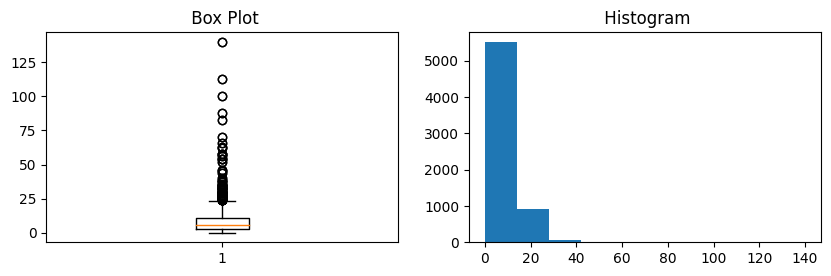

In [22]:
plt.figure(figsize=(10,6))

plt.subplot(2,2,1)
plt.boxplot(data2["UsefulCount"])
plt.title(" Box Plot")

plt.subplot(2,2,2)
plt.hist(data2["UsefulCount"])
plt.title(" Histogram")
data2.UsefulCount.skew()

0.13539917023288633

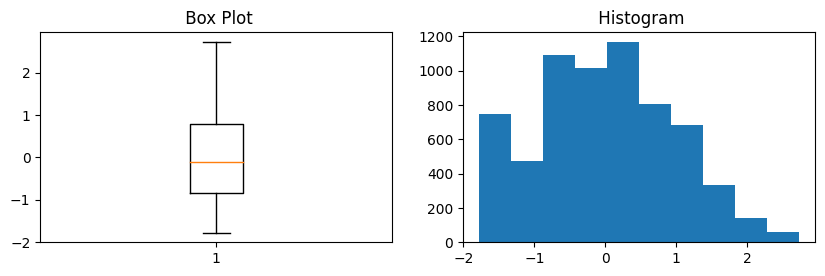

In [23]:
data_Usefulcount = pd.DataFrame(data2['UsefulCount'])

scaler = MinMaxScaler(feature_range=(1, 2))
power = PowerTransformer(method='box-cox')
pipeline = Pipeline(steps=[('s', scaler),('p', power)])
data_Usefulcount1 = pipeline.fit_transform(data_Usefulcount)

plt.figure(figsize=(10,6))

plt.subplot(2,2,1)
plt.boxplot(data_Usefulcount1)
plt.title(" Box Plot")

plt.subplot(2,2,2)
plt.hist(data_Usefulcount1)
plt.title(" Histogram")

data2['UsefulCount_boxcox'] = data_Usefulcount1
data2['UsefulCount_boxcox'].skew()

## EaseofUse

-1.0956719032464681

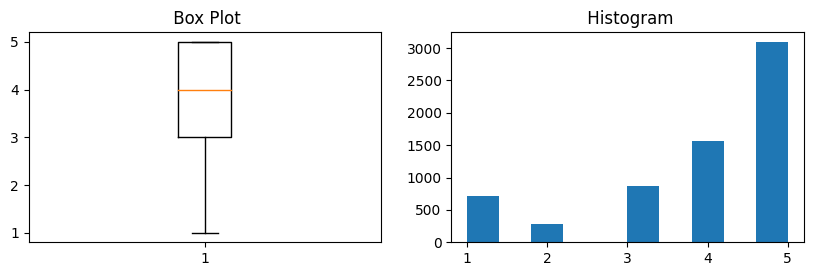

In [24]:
plt.figure(figsize=(10,6))

plt.subplot(2,2,1)
plt.boxplot(data2["EaseofUse"])
plt.title(" Box Plot")

plt.subplot(2,2,2)
plt.hist(data2["EaseofUse"])
plt.title(" Histogram")
data2.EaseofUse.skew()

-0.4695297334699221

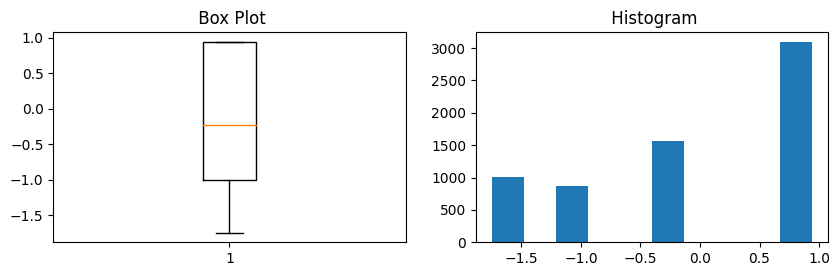

In [25]:
scaler = MinMaxScaler(feature_range=(1, 2))
power = PowerTransformer(method='box-cox')
pipeline = Pipeline(steps=[('s', scaler),('p', power)])

data_EaseofUse = pd.DataFrame(data2['EaseofUse'])
data_EaseofUse1 = pipeline.fit_transform(data_EaseofUse)

plt.figure(figsize=(10,6))

plt.subplot(2,2,1)
plt.boxplot(data_EaseofUse1)
plt.title(" Box Plot")

plt.subplot(2,2,2)
plt.hist(data_EaseofUse1)
plt.title(" Histogram")

data2['EaseofUse_boxcox'] = data_EaseofUse1
data2.EaseofUse_boxcox.skew()

## Satisfaction column

0.46899147382396195

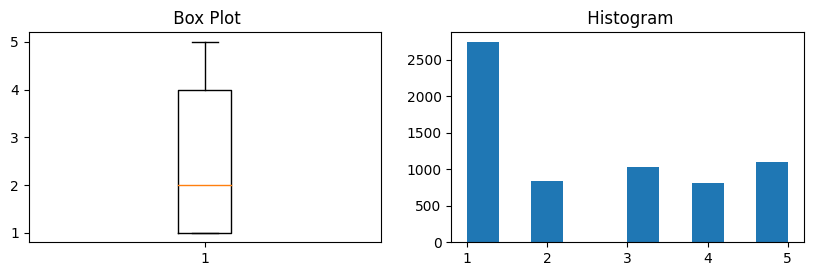

In [26]:
plt.figure(figsize=(10,6))

plt.subplot(2,2,1)
plt.boxplot(data2["Satisfaction"])
plt.title(" Box Plot")

plt.subplot(2,2,2)
plt.hist(data2["Satisfaction"])
plt.title(" Histogram")
data2.Satisfaction.skew()

## Effectiveness

-0.35269982353771245

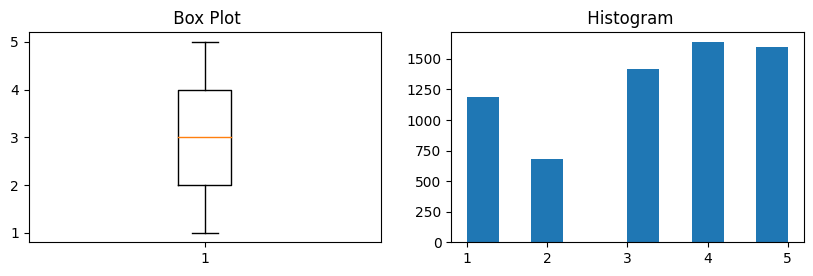

In [27]:
plt.figure(figsize=(10,6))

plt.subplot(2,2,1)
plt.boxplot(data2["Effectiveness"])
plt.title(" Box Plot")

plt.subplot(2,2,2)
plt.hist(data2["Effectiveness"])
plt.title(" Histogram")
data2.Effectiveness.skew()

### After checking the skewness and outliers, Usefulcount, easeofuse, effectiveness and satisfaction column has been processed

# New Feature creation: Sideeffect

In [28]:
mapping = {1: 5, 2: 4, 3: 3, 4: 2, 5: 1}
data2['Sideeffect'] = data2['Satisfaction'].map(mapping)
# data2.loc[data2['Satisfaction'] == 1, 'Sideeffect'] = data2.loc[data2['Satisfaction'] == 1,5, 'Sideeffect']

In [29]:
data2.columns

Index(['Name', 'Race', 'Age', 'Condition', 'Date', 'Drug', 'DrugId',
       'EaseofUse', 'Effectiveness', 'Reviews', 'Satisfaction', 'Sex', 'Sides',
       'UsefulCount', 'Year', 'Month', 'day_of_week', 'UsefulCount_boxcox',
       'EaseofUse_boxcox', 'Sideeffect'],
      dtype='object')

# Exploratory Data Analysis

## Top 20 Drugs based on No. of Users

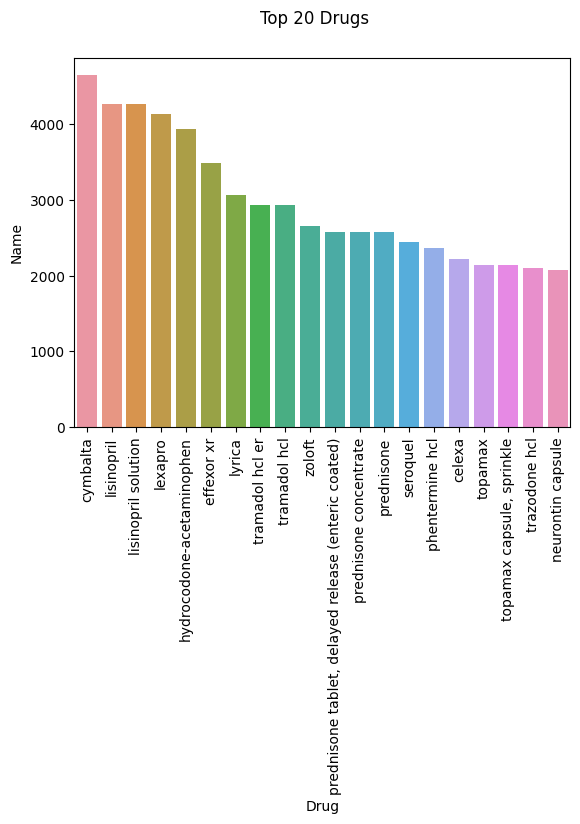

In [30]:
data_= data['Drug'].value_counts().head(20).reset_index()
data_.columns = ['Drug', 'Name']
sns.barplot(data=data_, x = 'Drug', y = 'Name')
plt.suptitle("Top 20 Drugs")
plt.xticks(rotation=90,fontsize=10)
plt.show()

#### Cymbalta tops the list followed by Lisinopril. It is to be noted that all the 20 drugs has been used by more than atleast 2000 people

## Top 15 Conditions

Text(0, 0.5, 'Users')

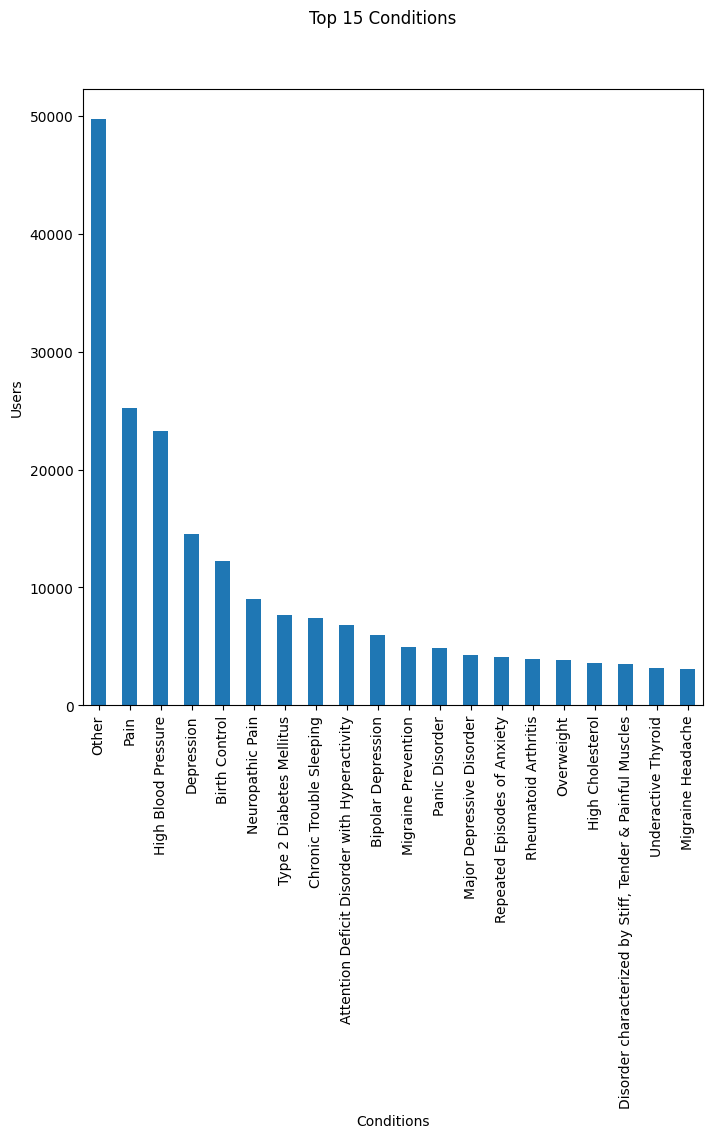

In [31]:
data['Condition'].value_counts().nlargest(20).plot(kind='bar',figsize=(8,8))
plt.suptitle("Top 15 Conditions")
plt.xlabel('Conditions')
plt.ylabel('Users')

#### As much as 50,000 users have reported other conditions followed by Pain topped the list with more than 25000 people reporting it.

# EDA on Licinopril

## Which gender is the predominant user?

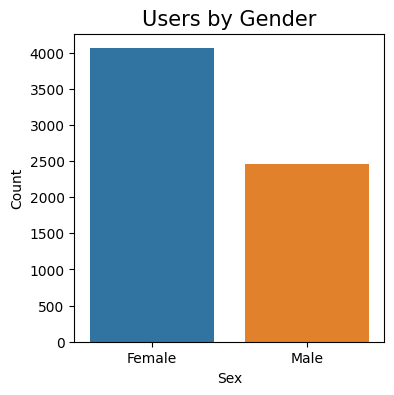

In [32]:
plt.figure(figsize = (4,4))
s=sns.countplot(x='Sex', data=data2)
plt.title('Users by Gender', fontsize=15)
plt.xlabel('Sex')
plt.ylabel('Count') 
plt.show()

#### Female users are predominant

#### Which race is the predominant user?

Text(0, 0.5, 'Count')

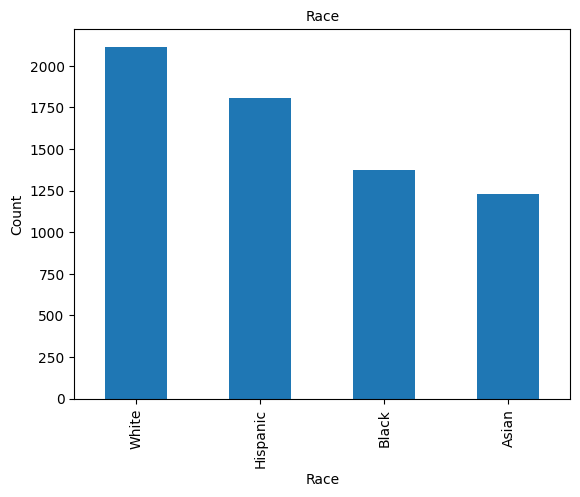

In [33]:
data2['Race'].value_counts().plot(kind='bar')
plt.title("Race", fontsize = 10)
plt.xlabel("Race", fontsize = 10)
plt.ylabel("Count", fontsize = 10)

#### In each race, which gender is the predominant user?

Text(0.5, 1.0, 'Users by Race and Gender')

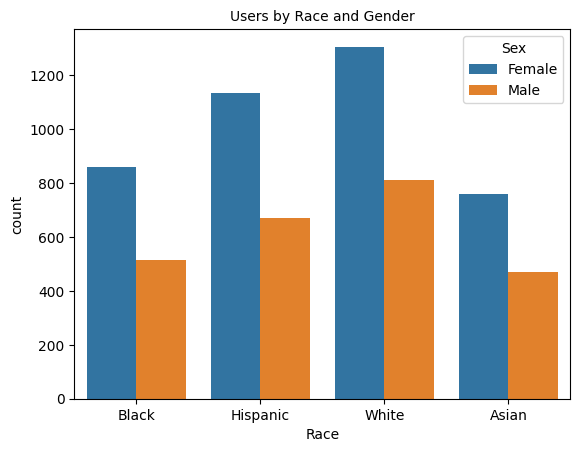

In [34]:
sns.countplot(x='Race',hue='Sex',data=data2)
plt.title("Users by Race and Gender", fontsize = 10)

#### In each age group, which gender is the predominant user?

Text(0.5, 1.0, 'Users by Age and Gender')

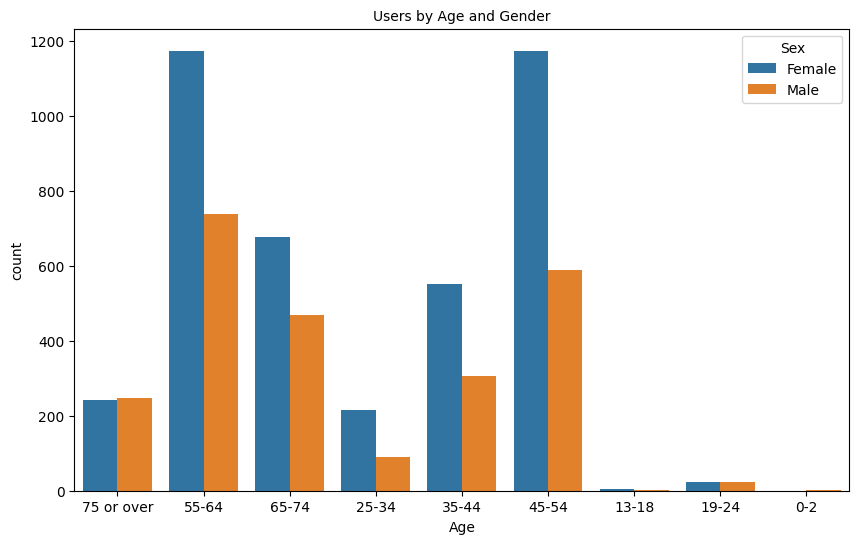

In [35]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Age',hue='Sex',data=data2)
plt.title("Users by Age and Gender", fontsize = 10)

#### In each year, how many reviews were collected?

Text(0, 0.5, 'Count of Reviews')

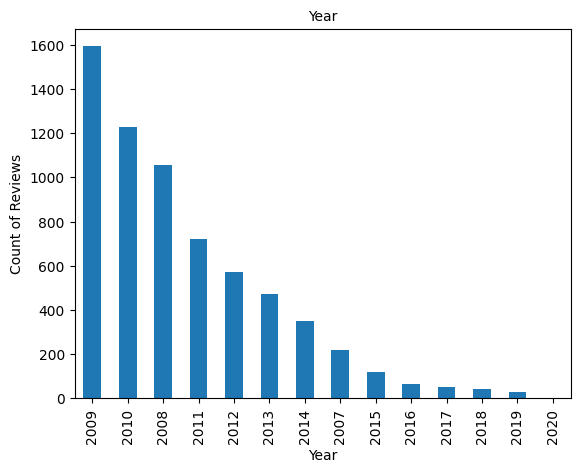

In [36]:
data2['Year'].value_counts().plot(kind='bar')
plt.title("Year", fontsize = 10)
plt.xlabel("Year", fontsize = 10)
plt.ylabel("Count of Reviews", fontsize = 10)

#### In each year, there is a gradual decrease in user reviews

#### how effective is the drug?

Text(0, 0.5, 'Count')

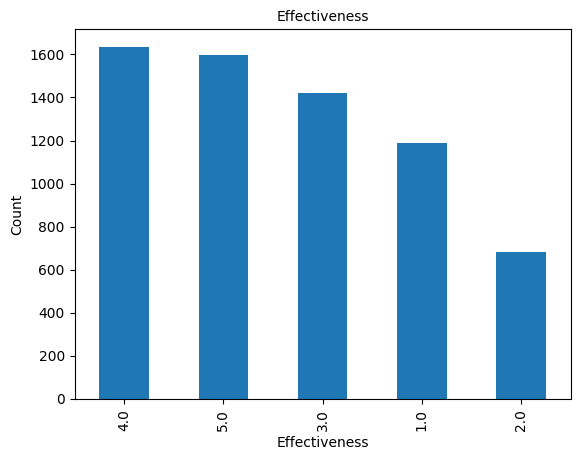

In [37]:
data2['Effectiveness'].value_counts().plot(kind='bar')
plt.title("Effectiveness", fontsize = 10)
plt.xlabel("Effectiveness", fontsize = 10)
plt.ylabel("Count", fontsize = 10)

#### The drug is fairly effective with around 1600 users voting a 4 rating to it.

#### How effective is the drug among both the gender category?

<Figure size 1000x800 with 0 Axes>

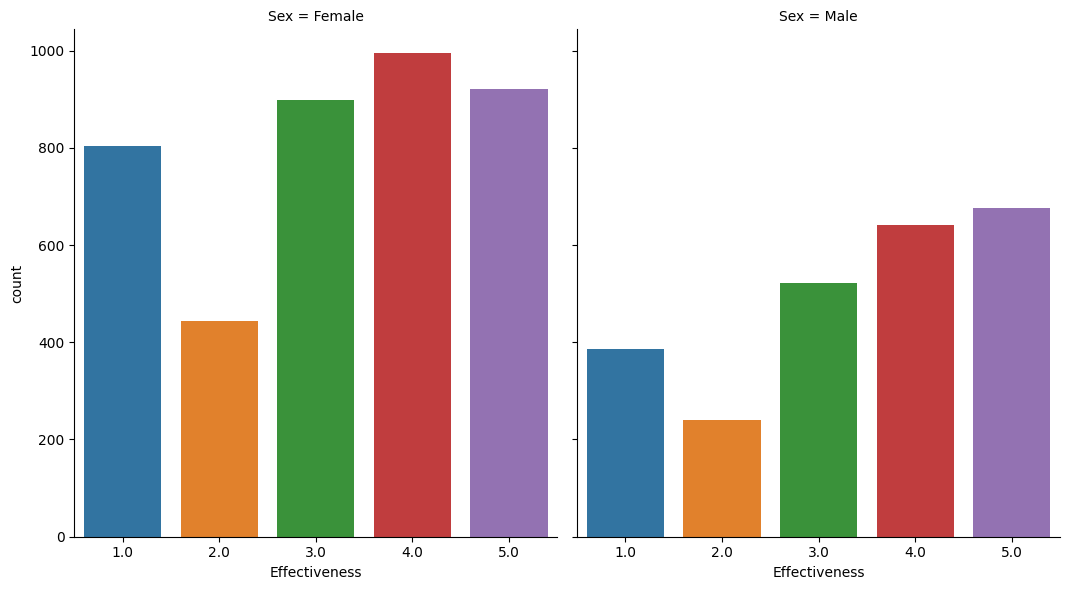

In [38]:
plt.figure(figsize=(10,8))
g = sns.catplot(x="Effectiveness",col="Sex",
                data=data2, kind="count",
                height=6,aspect =.9);

#### Both the users have given a mixed response

#### How many reported side effects for the drug?

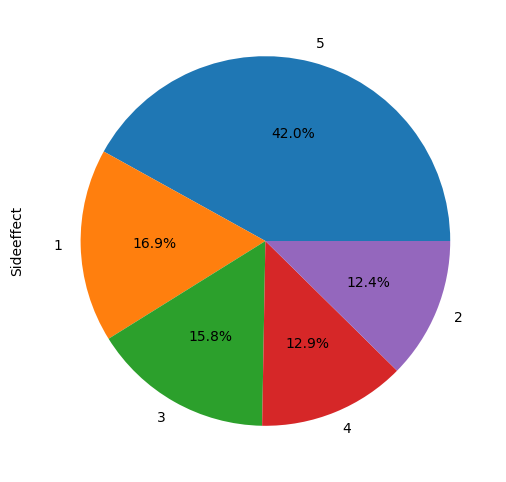

In [39]:
plt.figure(figsize=(6,6))
data2['Sideeffect'].value_counts().plot.pie(autopct='%1.1f%%')
plt.show()

#### 42% users reported extreme sideeffects with 1 being no side effect and 5 being extreme side effect

#### Which age group has reported most side effect?

<AxesSubplot: xlabel='Age', ylabel='count'>

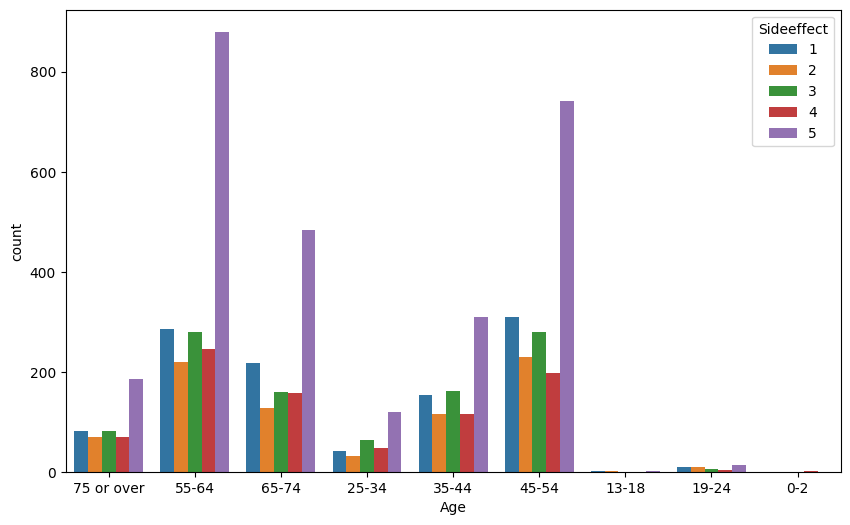

In [40]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Age',hue='Sideeffect',data=data2)

#### 55-64 age group has opinionated that they had extreme side effects

#### Among both the gender category, how is the sideeffects of the drug?

<Figure size 2000x1000 with 0 Axes>

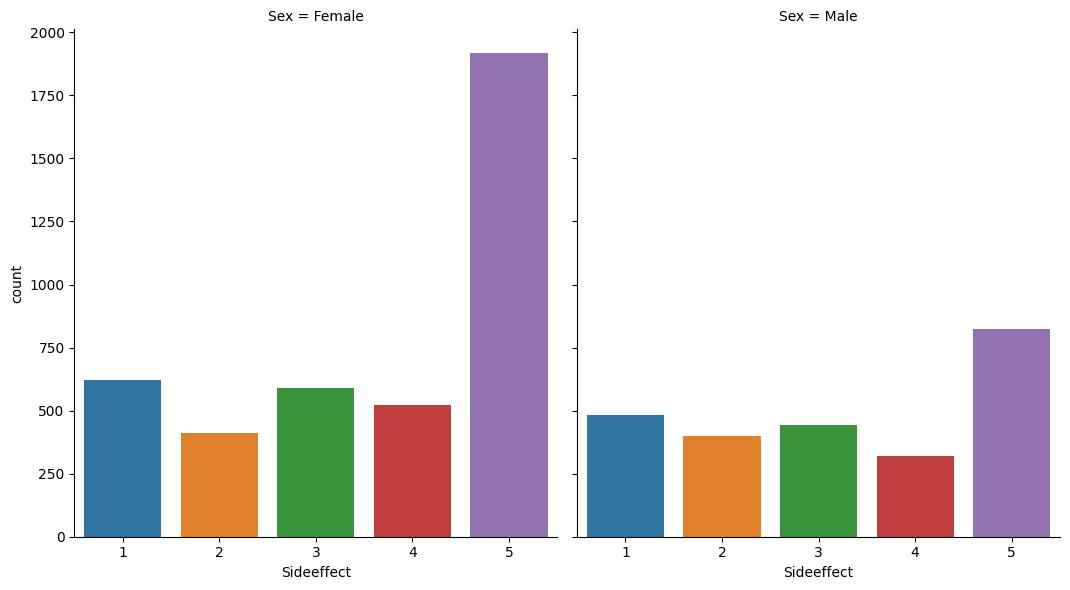

In [41]:
plt.figure(figsize=(20,10))

g = sns.catplot(x="Sideeffect",col="Sex",data=data2, kind="count",height=6,aspect =.9);

#### Female users have reported more extreme side effects

#### which race has reported extreme side effects?

<AxesSubplot: xlabel='Race', ylabel='count'>

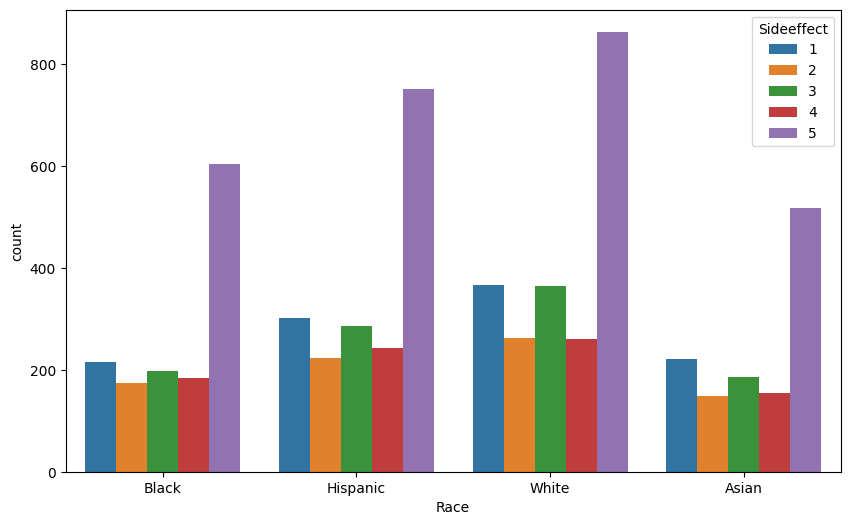

In [42]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Race',hue='Sideeffect',data=data2)

#### White and Hispanic users reported more extreme side effects

## Reviews

#### Let us look at a sample of Review

In [43]:
data2.Reviews.sample(5)

18888    I found that at times it controls my blood pre...
13583    This med caused me to develope a cronic dry co...
16150    I developed a terrible hacking cough in my fir...
16953    Been on it a month (5mg).  No noticeable side ...
16723    \nHas lowered my HBP but will look for a bette...
Name: Reviews, dtype: object

#### Let us define a function to clean the text in the review so as to generate meaningfull output. The plan is to rank the reviews as either positive or negative. But, so as to rank the reviews, we need a more samples than what we have here. So, we will train the algoithm on the complete parent dataset (containing data about all the medicines). The algorithm will get trained on satisfaction and reviews, which means, it will identify which reviews or specifically word consitutes positive review ( satisfaction > 3) and which one consitute negative reviews (satisfaction < 3). Then, the generated model will be used to generate review rank ( 1 for positve and 0 for negative) for us in our dataset. Kindly note, the review rank for entries where satisfaction > 3 is 1 and for satisfaction < 3 is 0. The entries with satisfaction == 3 will be fed to the model to generate review rank values. Finally, our dataset will be complete after this.

# Cleaning the Global Review column

In [44]:
if data['Reviews'].dtype.kind == "O":
        data['Reviews'] = data['Reviews'].str.strip()

In [45]:
data['Reviews']= data['Reviews'].astype(str)

In [46]:
%%time

nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])
STOPWORDS = set(sklearn_stop_words).union(set(stopwords.words("english")))

def clean_review(text, STOPWORDS=STOPWORDS, nlp=nlp):
    """Cleans up text"""
    
    def rep_emo(text, placeholder_pos=' happyemoticon ', placeholder_neg=' sademoticon '):
        """Replace emoticons"""
        # Credit https://github.com/shaheen-syed/Twitter-Sentiment-Analysis/blob/master/helper_functions.py
        emoticons_pos = [":)", ":-)", ":p", ":-p", ":P", ":-P", ":D",":-D", ":]", ":-]", ";)", ";-)",
                         ";p", ";-p", ";P", ";-P", ";D", ";-D", ";]", ";-]", "=)", "=-)", "<3"]
        emoticons_neg = [":o", ":-o", ":O", ":-O", ":(", ":-(", ":c", ":-c", ":C", ":-C", ":[", ":-[",
                         ":/", ":-/", ":\\", ":-\\", ":n", ":-n", ":u", ":-u", "=(", "=-(", ":$", ":-$"]

        for e in emoticons_pos:
            text = text.replace(e, placeholder_pos)

        for e in emoticons_neg:
            text = text.replace(e, placeholder_neg)   
        return text

    def rep_punct(text):
        """Replace all punctuation with space"""
        for c in string.punctuation:
            text = text.replace(c, " ")
        return text

    def rem_stop_num(text):
        """Remove stop words and anything starting with number"""
        return " ".join(word for word in text.split() if word not in STOPWORDS and not word[0].isdigit())

    def lemmatize(text):
        """Return lemmas of tokens in text"""
        return " ".join(tok.lemma_.lower().strip() for tok in nlp(text) if tok.lemma_ != "-PRON-")  

    return lemmatize(rem_stop_num(rep_punct(rep_emo(text))))

mldf = data[["Satisfaction", "Reviews"]]
mldf["Reviews"] = mldf["Reviews"].apply(clean_review)

# remove any rows with new empty strings following the clean-up
mldf["Reviews"].replace("", np.nan, inplace=True)
mldf.dropna(inplace=True)
# adding indexes as "index" column for later use to recreate same splits 
mldf.reset_index(inplace=True)

CPU times: user 27min 29s, sys: 874 ms, total: 27min 30s
Wall time: 27min 31s


#### Review column is cleaned. A new column satisfaction1 is generated which will help in identifiying postive and negative reviews for algorithm where 0 is negative, 2 is positive and 1 is neutral for satisfaction < 3, > 3 and ==3 respectively. We will omit the neutral reviews.

In [47]:
def relabel(x):
    return 0 if x < 3 else 1 if x == 3 else 2

mldf["Satisfaction1"] = mldf["Satisfaction"].apply(relabel)

# Generating Text processing Model

In [48]:
train_set, test_set = train_test_split(mldf, test_size=0.25, random_state=0, stratify=mldf["Satisfaction1"])
train_index = train_set.index
test_index = test_set.index
print(train_set.shape)
print(test_set.shape)

(240564, 4)
(80189, 4)


In [49]:
%%time
train_set = train_set[train_set["Satisfaction1"] != 1]
test_set = test_set[test_set["Satisfaction1"] != 1]
print(train_set.shape)
print(test_set.shape)

vectorizer = TfidfVectorizer(max_features=2500, min_df=10, max_df=0.8)
X_train = vectorizer.fit_transform(train_set["Reviews"]).toarray()
X_test = vectorizer.transform(test_set["Reviews"]).toarray()
y_train = train_set["Satisfaction1"].values
y_test = test_set["Satisfaction1"].values

model = RandomForestClassifier(min_samples_split=6, random_state=0)
model.fit(X_train, y_train)

acc_train = accuracy_score(y_train, model.predict(X_train))
print(f"\nAccuracy in train set: {acc_train:.2}")
predictions = model.predict(X_test)
acc_test = accuracy_score(y_test, predictions)
print(f"\nAccuracy in test  set: {acc_test:.2}\n")
print(classification_report(y_test, predictions))

(207859, 4)
(69287, 4)

Accuracy in train set: 0.99

Accuracy in test  set: 0.83

              precision    recall  f1-score   support

           0       0.83      0.80      0.82     32110
           2       0.83      0.86      0.85     37177

    accuracy                           0.83     69287
   macro avg       0.83      0.83      0.83     69287
weighted avg       0.83      0.83      0.83     69287

CPU times: user 15min 18s, sys: 8.35 s, total: 15min 26s
Wall time: 15min 27s


#### We got an accuracy of 84%.

#### Let us the clean the review specific to our drug

In [50]:
data2["Reviews"] = data2["Reviews"].apply(clean_review)

#### Let us the rank the reviews by creating a function for the same

In [51]:

def predict_rank(text):
    cleaned_text = [clean_review(text)]
    padded_text = vectorizer.transform(cleaned_text)
    p = model.predict(padded_text)[0]
    if (p == 0):
        return 0
    else :
        return 1
    
def predict_rank1(rank):
    if (rank < 3):
        return 0
    else:
        return 1
    
# predict_rank("I loved it")
data2['Reviews_Rank'] = data2['Satisfaction']
data2.loc[data2['Satisfaction'] < 3, 'Reviews_Rank'] = data2.loc[data2['Satisfaction'] < 3, 'Reviews_Rank'].apply(predict_rank1)
data2.loc[data2['Satisfaction'] > 3, 'Reviews_Rank'] = data2.loc[data2['Satisfaction'] > 3, 'Reviews_Rank'].apply(predict_rank1)
data2.loc[data2['Satisfaction'] == 3, 'Reviews_Rank'] = data2.loc[data2['Satisfaction'] == 3, 'Reviews'].apply(predict_rank)
data2['Reviews_Rank'].unique()

array([1., 0.])

#### Columns Name has unique values so will be dropped. Drug, DrugId, Condition, Date, Easeofuse, usefulcount, sides will be dropped. Race, Sex, Year, Month, Dayofweek will be onehot encoded. Satisfaction will be segregated based on the values as nil, mild, moderate, sever, extreme based on values of 5, 4, 3, 2, 1 respectively. The assumption being that thet satisfaction is a parameter that gets affected by side effects in case of patients.

In [52]:
data2.drop(['Name','Condition','Date','Drug','DrugId','EaseofUse','Sides','UsefulCount'], axis=1, inplace = True)

In [53]:
data2.Month = data2.Month.astype(str)
data2.Year = data2.Year.astype(str)
data_encod = data2[['Race', 'Age','Sex','Month','Year','day_of_week']]
data_num = data2[['Effectiveness']]
data2.columns

Index(['Race', 'Age', 'Effectiveness', 'Reviews', 'Satisfaction', 'Sex',
       'Year', 'Month', 'day_of_week', 'UsefulCount_boxcox',
       'EaseofUse_boxcox', 'Sideeffect', 'Reviews_Rank'],
      dtype='object')

# Encoding : One Hot Encoding

In [54]:
data_encod = pd.get_dummies(data_encod)
data_encod

,Race_Asian,Race_Black,Race_Hispanic,Race_White,Age_0-2,Age_13-18,Age_19-24,Age_25-34,Age_35-44,Age_45-54,...,Year_2018,Year_2019,Year_2020,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
9203,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
9209,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
9215,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
9221,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
9227,0,1,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18981,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
18982,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
18984,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
18985,0,0,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


# Scaling : Standard Scaling

In [55]:
from sklearn.preprocessing import StandardScaler
mm = StandardScaler()
data_num = mm.fit_transform(data_num)
data_num = pd.DataFrame(data_num, columns = ['Effectiveness'])
data_num

,Effectiveness
0,0.517259
1,1.226128
2,1.226128
3,0.517259
4,-1.609348
...,...
6521,-1.609348
6522,-1.609348
6523,1.226128
6524,-1.609348


In [56]:
data3 = data_encod
data3['Effectiveness'] = data_num.values
data3

,Race_Asian,Race_Black,Race_Hispanic,Race_White,Age_0-2,Age_13-18,Age_19-24,Age_25-34,Age_35-44,Age_45-54,...,Year_2019,Year_2020,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,Effectiveness
9203,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0.517259
9209,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1.226128
9215,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1.226128
9221,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0.517259
9227,0,1,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,-1.609348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18981,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,-1.609348
18982,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,-1.609348
18984,0,0,1,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1.226128
18985,0,0,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,-1.609348
